In [106]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
from google.colab import files


uploaded = files.upload()


In [107]:
df = pd.read_csv('full_month_grid.csv')

In [108]:
df['time']=pd.to_datetime(df['time'])

In [109]:
df

,time,rate
0,2013-11-01 00:00:00,710841.049680
1,2013-11-01 00:10:00,689606.902359
2,2013-11-01 00:20:00,673841.228490
3,2013-11-01 00:30:00,641464.168550
4,2013-11-01 00:40:00,623366.124033
...,...,...
8923,2014-01-01 23:10:00,438645.623391
8924,2014-01-01 23:20:00,428536.762595
8925,2014-01-01 23:30:00,417263.649372
8926,2014-01-01 23:40:00,407067.355914


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    8928 non-null   datetime64[ns]
 1   rate    8928 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 139.6 KB


In [111]:
fig = px.line(df.reset_index(), x='time', y='rate')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(step="all")
        ])
    )
)
fig.show()

In [112]:
from fbprophet import Prophet

In [113]:
df3=df.reset_index()[['time','rate']].rename({'time':'ds','rate':'y'}, axis='columns')

In [114]:
df3

,ds,y
0,2013-11-01 00:00:00,710841.049680
1,2013-11-01 00:10:00,689606.902359
2,2013-11-01 00:20:00,673841.228490
3,2013-11-01 00:30:00,641464.168550
4,2013-11-01 00:40:00,623366.124033
...,...,...
8923,2014-01-01 23:10:00,438645.623391
8924,2014-01-01 23:20:00,428536.762595
8925,2014-01-01 23:30:00,417263.649372
8926,2014-01-01 23:40:00,407067.355914


In [115]:
train = int(len(df3) * 0.7)
test = len(df3) - train
train, test = df3.iloc[0:train], df3.iloc[train:len(df3)]
print(train.shape, test.shape)

(6249, 2) (2679, 2)


In [116]:
m = Prophet(changepoint_range=0.95)

In [117]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [123]:
future = m.make_future_dataframe(periods=432,freq='H')
future.tail()

,ds
6676,2014-01-01 05:20:00
6677,2014-01-01 06:20:00
6678,2014-01-01 07:20:00
6679,2014-01-01 08:20:00
6680,2014-01-01 09:20:00


In [124]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6676,2014-01-01 05:20:00,3.467404e+05,-2.238877e+06,2.879047e+06
6677,2014-01-01 06:20:00,4.365238e+05,-2.135078e+06,2.984630e+06
6678,2014-01-01 07:20:00,6.063289e+05,-1.915762e+06,3.142809e+06
6679,2014-01-01 08:20:00,8.192766e+05,-1.759579e+06,3.392271e+06
6680,2014-01-01 09:20:00,1.013742e+06,-1.539542e+06,3.605503e+06


In [125]:
results=pd.concat([df3.set_index('ds')['y'],forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]],axis=1)

In [126]:
results.shape

(8928, 4)

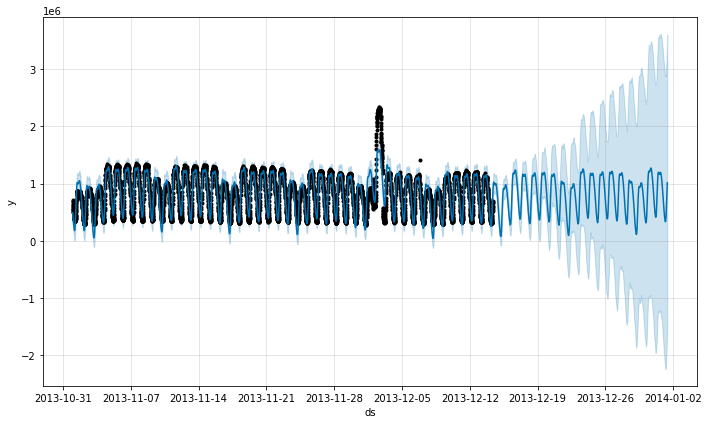

In [127]:
fig1 = m.plot(forecast)

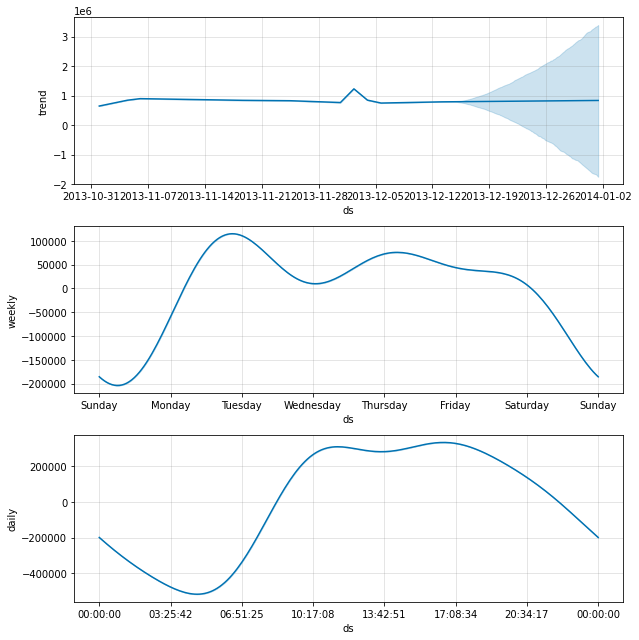

In [128]:
comp=m.plot_components(forecast)

In [129]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2013-11-01 00:00:00,710841.049680,492634.347365,330883.878737,657589.747214
2013-11-01 00:10:00,689606.902359,475715.149050,303122.358356,640830.294787
2013-11-01 00:20:00,673841.228490,459101.080402,300730.039725,618172.680387
2013-11-01 00:30:00,641464.168550,442823.660240,273118.784303,606351.405851
2013-11-01 00:40:00,623366.124033,426906.797956,271615.027797,579139.002031
...,...,...,...,...
2014-01-01 23:10:00,438645.623391,NaN,NaN,NaN
2014-01-01 23:20:00,428536.762595,NaN,NaN,NaN
2014-01-01 23:30:00,417263.649372,NaN,NaN,NaN


In [130]:
results['error'] = results['y'] - results['yhat']

In [131]:
results["uncertainty"] = results['yhat_upper'] - results['yhat_lower']

In [132]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2013-11-01 00:00:00,710841.049680,492634.347365,330883.878737,657589.747214,218206.702315,326705.868476
2013-11-01 00:10:00,689606.902359,475715.149050,303122.358356,640830.294787,213891.753310,337707.936431
2013-11-01 00:20:00,673841.228490,459101.080402,300730.039725,618172.680387,214740.148088,317442.640662
2013-11-01 00:30:00,641464.168550,442823.660240,273118.784303,606351.405851,198640.508310,333232.621548
2013-11-01 00:40:00,623366.124033,426906.797956,271615.027797,579139.002031,196459.326077,307523.974234
...,...,...,...,...,...,...
2014-01-01 23:10:00,438645.623391,NaN,NaN,NaN,NaN,NaN
2014-01-01 23:20:00,428536.762595,NaN,NaN,NaN,NaN,NaN
2014-01-01 23:30:00,417263.649372,NaN,NaN,NaN,NaN,NaN


In [133]:
results[results['error'].abs() >  1.5*results['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2013-12-02 08:20:00,1.750513e+06,1.231782e+06,1.067917e+06,1.395404e+06,518731.216554,327487.021671
2013-12-02 08:30:00,1.821296e+06,1.266828e+06,1.099812e+06,1.420247e+06,554468.405321,320434.712936
2013-12-02 08:40:00,1.868925e+06,1.301008e+06,1.134144e+06,1.469136e+06,567916.595820,334992.300761
2013-12-02 08:50:00,1.934915e+06,1.334035e+06,1.166719e+06,1.482069e+06,600879.441463,315350.068546
2013-12-02 09:00:00,2.003883e+06,1.365640e+06,1.205965e+06,1.526418e+06,638243.266349,320452.642225
...,...,...,...,...,...,...
2013-12-02 19:10:00,2.126416e+06,1.475185e+06,1.301813e+06,1.633818e+06,651230.980592,332005.193451
2013-12-02 19:20:00,2.065399e+06,1.462996e+06,1.302822e+06,1.620569e+06,602403.302393,317746.173917
2013-12-02 19:30:00,2.016192e+06,1.450468e+06,1.278779e+06,1.605747e+06,565724.171148,326968.547141


In [134]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) >  1.5*x['uncertainty']) else 'No', axis=1)

In [135]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2013-11-01 00:00:00,710841.049680,492634.347365,330883.878737,657589.747214,218206.702315,326705.868476,No
2013-11-01 00:10:00,689606.902359,475715.149050,303122.358356,640830.294787,213891.753310,337707.936431,No
2013-11-01 00:20:00,673841.228490,459101.080402,300730.039725,618172.680387,214740.148088,317442.640662,No
2013-11-01 00:30:00,641464.168550,442823.660240,273118.784303,606351.405851,198640.508310,333232.621548,No
2013-11-01 00:40:00,623366.124033,426906.797956,271615.027797,579139.002031,196459.326077,307523.974234,No
...,...,...,...,...,...,...,...
2014-01-01 23:10:00,438645.623391,NaN,NaN,NaN,NaN,NaN,No
2014-01-01 23:20:00,428536.762595,NaN,NaN,NaN,NaN,NaN,No
2014-01-01 23:30:00,417263.649372,NaN,NaN,NaN,NaN,NaN,No


In [136]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(step="all")
        ])
    )
)
fig.show()